## System Setup

In [1]:
# Find CPU info
!grep -m1 'model name' /proc/cpuinfo | awk -F": " '{print $2}'
!grep 'cpu cores' /proc/cpuinfo | awk -F": " '{a[cores]+=$2}END{print "CPU cores: " a[cores]}'

Intel(R) Xeon(R) CPU @ 2.20GHz
CPU cores: 32


In [2]:
# Find Ram Info
!grep MemTotal /proc/meminfo | awk '{printf "%.1fGB RAM", $2 / 1024 / 1024}'

51.0GB RAM

In [3]:
# Find GPU info
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [4]:
!python --version

Python 3.10.12


In [5]:
!R --version

R version 4.3.1 (2023-06-16) -- "Beagle Scouts"
Copyright (C) 2023 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under the terms of the
GNU General Public License versions 2 or 3.
For more information about these matters see
https://www.gnu.org/licenses/.



In [6]:
#Install torch manually from prebuilt binaries since colab use cu11.8 which does not build
!wget https://storage.googleapis.com/torch-lantern-builds/packages/cu117/0.11.0/src/contrib/torch_0.11.0_R_x86_64-pc-linux-gnu.tar.gz
!Rscript -e 'install.packages("torch_0.11.0_R_x86_64-pc-linux-gnu.tar.gz", repos = NULL)'

--2023-08-29 00:33:19--  https://storage.googleapis.com/torch-lantern-builds/packages/cu117/0.11.0/src/contrib/torch_0.11.0_R_x86_64-pc-linux-gnu.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.170.128, 173.194.174.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.170.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/gzip]
Saving to: ‘torch_0.11.0_R_x86_64-pc-linux-gnu.tar.gz’

torch_0.11.0_R_x86_     [            <=>     ]   1.83G  25.1MB/s    in 76s     

2023-08-29 00:34:36 (24.6 MB/s) - ‘torch_0.11.0_R_x86_64-pc-linux-gnu.tar.gz’ saved [1966658359]

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
* installing *binary* package ‘torch’ ...
* DONE (torch)


In [7]:
# Install BKTR
!Rscript -e "library(devtools); devtools::install_github('julien-hec/BKTR', ref = 'main')"

Loading required package: usethis
openssl     (2.0.6 -> 2.1.0  ) [CRAN]
curl        (5.0.0 -> 5.0.2  ) [CRAN]
Rcpp        (NA    -> 1.0.11 ) [CRAN]
sp          (NA    -> 2.0-0  ) [CRAN]
png         (NA    -> 0.1-8  ) [CRAN]
isoband     (0.2.6 -> 0.2.7  ) [CRAN]
gtable      (0.3.3 -> 0.3.4  ) [CRAN]
bit         (4.0.4 -> 4.0.5  ) [CRAN]
httr        (1.4.6 -> 1.4.7  ) [CRAN]
bitops      (NA    -> 1.0-7  ) [CRAN]
jpeg        (NA    -> 0.1-10 ) [CRAN]
plyr        (NA    -> 1.8.8  ) [CRAN]
RgoogleMaps (NA    -> 1.4.5.3) [CRAN]
ggplot2     (3.4.2 -> 3.4.3  ) [CRAN]
collections (NA    -> 0.3.7  ) [CRAN]
coro        (NA    -> 1.0.3  ) [CRAN]
ggmap       (NA    -> 3.0.2  ) [CRAN]
R6P         (NA    -> 0.3.0  ) [CRAN]
Installing 18 packages: openssl, curl, Rcpp, sp, png, isoband, gtable, bit, httr, bitops, jpeg, plyr, RgoogleMaps, ggplot2, collections, coro, ggmap, R6P
Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/cont

In [8]:
# Ragg was causing some issues when saving plots on this machine, seems to be
# caused by incompatible versions so we reinstall it
!Rscript -e "install.packages('ragg')"

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/ragg_1.2.5.tar.gz'
Content type 'application/x-gzip' length 427859 bytes (417 KB)
downloaded 417 KB

* installing *source* package ‘ragg’ ...
** package ‘ragg’ successfully unpacked and MD5 sums checked
** using staged installation
Found pkg-config cflags and libs!
Using PKG_CFLAGS=-I/usr/include/freetype2 -I/usr/include/libpng16 -I/usr/include/x86_64-linux-gnu
Using PKG_LIBS=-lfreetype -lpng16 -lz -ltiff -ljpeg -ljpeg
** libs
using C++ compiler: ‘g++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’
using C++11
g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG  -I'/usr/lib/R/site-library/systemfonts/include' -I'/usr/lib/R/site-library/textshaping/include'    -I./agg/include -I/usr/include/freetype2 -I/usr/include/libpng16 -I/usr/include/x86_64-linux-gnu -fpic  -g -O2 -ffile-prefix-map=/build/r-base-MHXHhT/r-base-4.3.1=. -fstack-protector-strong -Wformat -Werror=form

## Notes
This is an extension to reflect the late addition of plot_y_estimates function.

In theory it could be merged with the BKTR-S5_2-SimuAnalysis.ipynb file. But we keep it separate, so that we don't have to change all the processing (CPU) time of the article.

You can see that the values did not change in the summary except for processing time.

## Analysis

In [9]:
sh = f"""
library(BKTR)
library(ggplot2)

# Set seed
TSR$set_params(seed = 1, fp_device = 'cpu')

# Use specific covariance matrix for simulation
matern_lengthscale <- KernelParameter$new(value = 14)
se_lengthscale <- KernelParameter$new(value = 5)
spatial_kernel <- KernelMatern$new(
  lengthscale = matern_lengthscale,
  smoothness_factor = 5
)
temporal_kernel <- KernelSE$new(lengthscale = se_lengthscale)

# Simulate data
simu_data <- simulate_spatiotemporal_data(
  nb_locations=100,
  nb_time_points=150,
  nb_spatial_dimensions=2,
  spatial_scale=10,
  time_scale=10,
  spatial_covariates_means=c(0, 2, 4),
  temporal_covariates_means=c(1, 3),
  spatial_kernel=spatial_kernel,
  temporal_kernel=temporal_kernel,
  noise_variance_scale=1
)

# Create Regressor
bktr_regressor <- BKTRRegressor$new(
  data_df = simu_data$data_df,
  spatial_kernel = KernelMatern$new(smoothness_factor = 5),
  spatial_positions_df = simu_data$spatial_positions_df,
  temporal_kernel = KernelSE$new(),
  temporal_positions_df = simu_data$temporal_positions_df,
  has_geo_coords=FALSE
)

# MCMC sampling
bktr_regressor$mcmc_sampling()

# Print Summary
summary(bktr_regressor)

# Print Beta Errors (Removing Time and Location columns)
beta_err <- unlist(abs(
    bktr_regressor$beta_estimates[, -c(1, 2)]
    - simu_data$beta_df[, -c(1, 2)]
))
print(sprintf('Beta RMSE: %.4f', sqrt(mean(beta_err^2))))
print(sprintf('Beta MAE: %.4f', mean(abs(beta_err))))

fig_1 <- plot_y_estimates(bktr_regressor, fig_title=NULL) + theme(text=element_text(family='Helvetica'))
ggsave('/content/5_2_simu_y_estimates_fig.png', fig_1, width=5, height=5, units = 'in')
"""

with open('5_2_simu_analysis.R', 'w') as file:
  file.write(sh)

!Rscript 5_2_simu_analysis.R

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)
[W BatchLinearAlgebra.cpp:2121] Warning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (function operator())
[1] "Iter 1     | Elapsed Time:     2.71s | MAE:  2.9356 | RMSE:  3.7555"
[1] "Iter 2     | Elapsed Time:     2.96s | MAE:  1

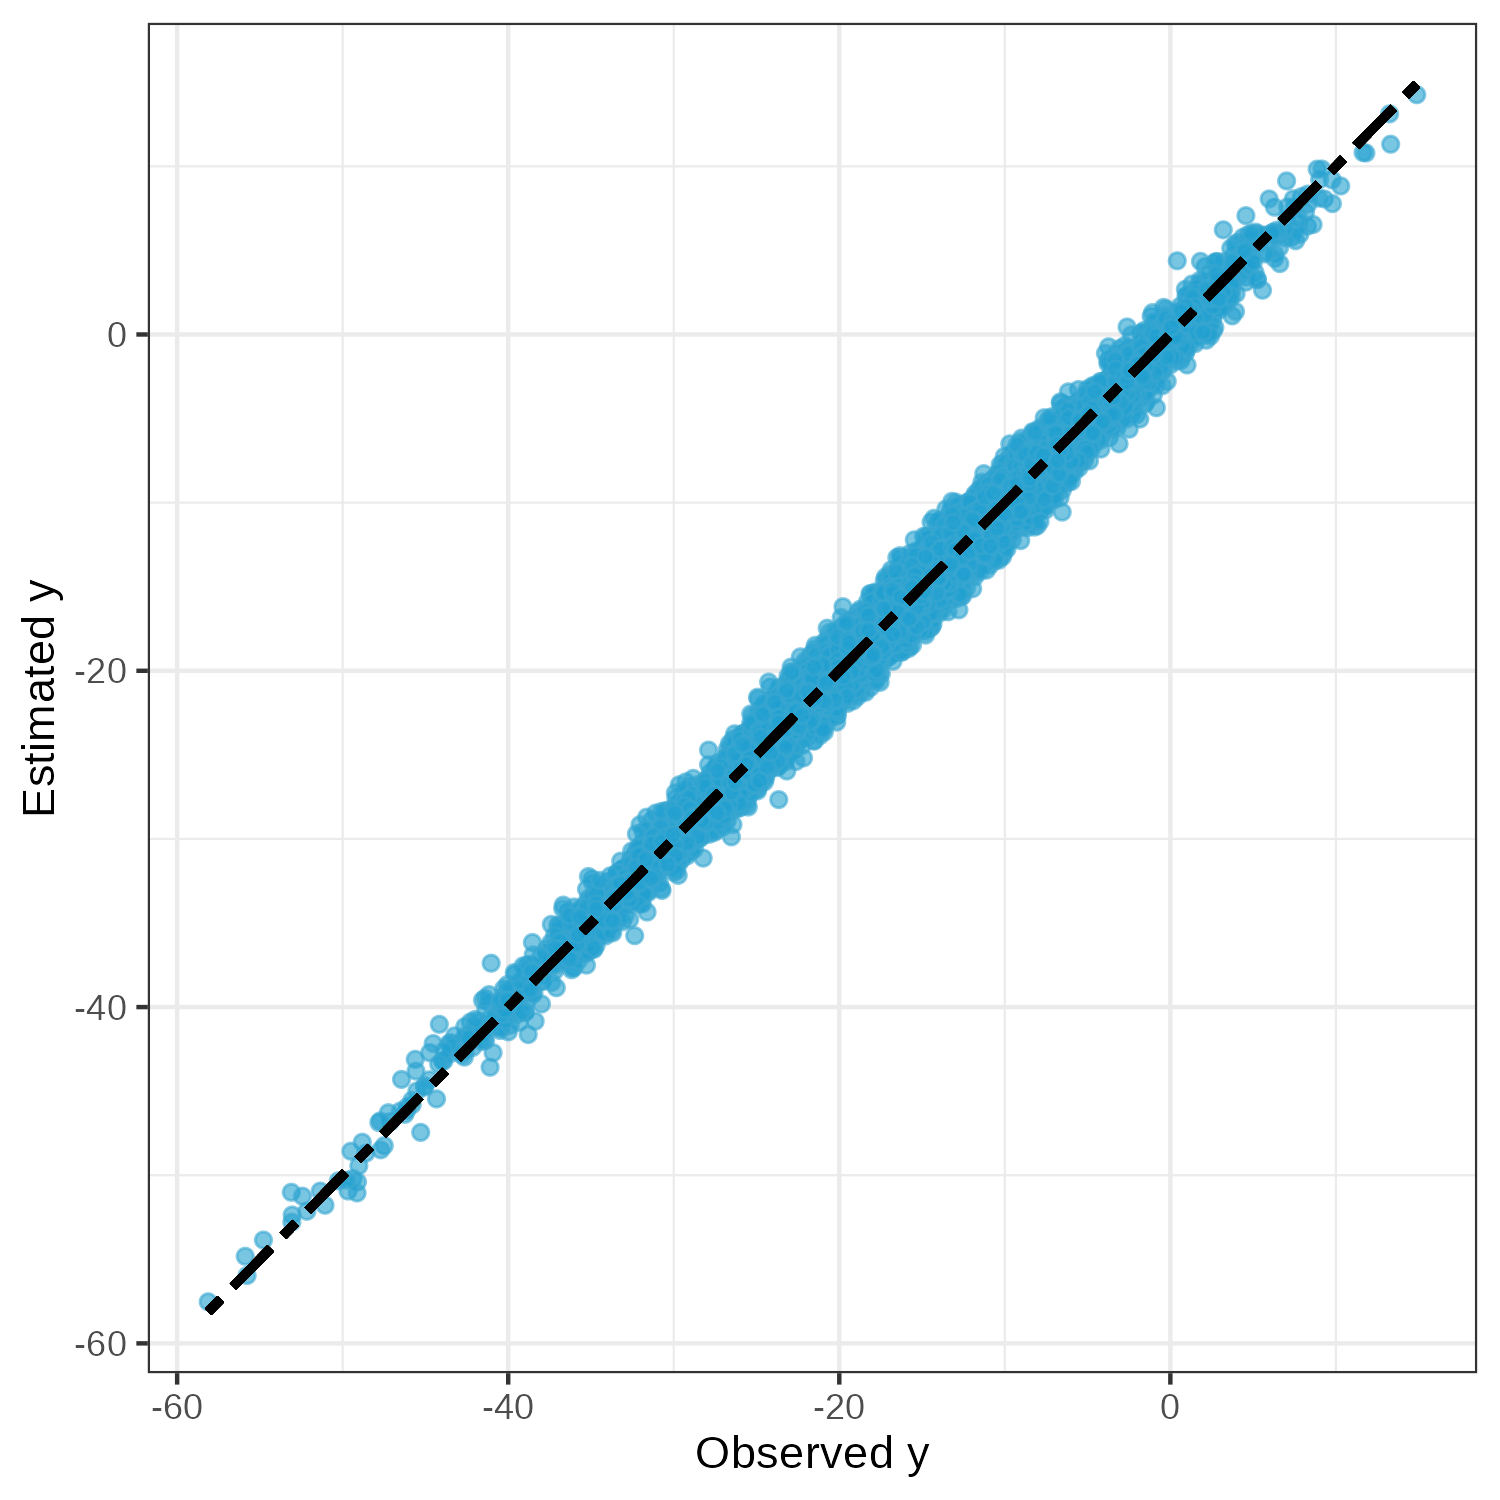

In [10]:
# Simply reopen the saved graph to show it in the notebook
from IPython.display import Image
Image('/content/5_2_simu_y_estimates_fig.png', width=800)